# Convolutional EncoderDecoder Model for Cancer dataset

In [2]:
# coding: utf-8

# Import Keras modules

import keras
from keras.models import load_model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam

# Import Convolutional Model

# from model.auto_encoder_model import set_ae
from model.auto_encoder_model_256 import set_ae
from model.unet_model import UNet, dice_coef, dice_coef_loss

# Import Usuful modules

import os
import pickle
import numpy as np
import cv2
from glob import glob
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
% matplotlib inline

Using TensorFlow backend.


## Load dataset

In [99]:
batch_size = 32
num_classes = 2
epochs = 200
saveDir = "./data/"
if not os.path.isdir(saveDir):
    os.makedirs(saveDir)
    
img_files = glob('./cropped_test/*.tif')
X = []
Y = []
for img_file in img_files:
    #img = cv2.imread(img_file, 0)
    #Y.append(img)
    img = cv2.imread(img_file)
    img = (img - np.mean(img))/np.std(img)*16+64
    
    X.append(img[:,:,::-1])
#x_train = X
# x_train, x_test = train_test_split(X, test_size=0.2, random_state=45)

# normalize data
x_train = np.asarray(X).astype('float32')
x_train /= 255
#x_train = x_train[:,:,:,np.newaxis]

# show data size
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')

x_train shape: (660, 256, 256, 3)
660 train samples


In [100]:
# show original image and reconstructed image
def showOrigDec(orig, dec, num=10):
    n = num
    plt.figure(figsize=(20, 4))

    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i+1)
        plt.imshow(orig[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i +1 + n)
        plt.imshow(dec[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

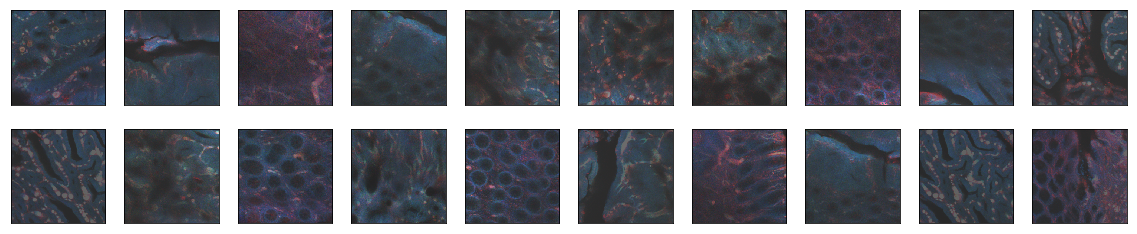

In [101]:
showOrigDec(x_train[:10], x_train[50:])

## Load Convolutional Model

In [ ]:
# AutoEncoder model
model = set_ae(channel=3)
model.compile(optimizer='adam', loss='binary_crossentropy')

# Unet model
# network = UNet(3, 3, 64)
# model = network.get_model(to_png=True, png_file='unet_model.png')
# model.compile(loss=dice_coef_loss, optimizer=Adam(lr=0.01), metrics=[dice_coef])

In [82]:
# Variational AutoEncoder model
from keras.layers import Input, Dense, Lambda, Flatten, Reshape, Layer
from keras.layers import Conv2D, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras import metrics

batch_size = 32
input_shape = (256,256,3)
img_rows,img_cols = input_shape[:2]
latent_dim = 2
intermediate_dim = 256
epochs = 1500
epsilon_std = 1.0

# encoder architecture
x = Input(shape=input_shape)
conv_1 = Conv2D(16,
                kernel_size=(2, 2),
                padding='same', activation='relu',
                strides=(2, 2))(x)
conv_2 = Conv2D(32,
                kernel_size=(2, 2),
                padding='same', activation='relu',
                strides=(2, 2))(conv_1)
conv_3 = Conv2D(32,
                kernel_size=(2, 2),
                padding='same', activation='relu',
                strides=(2, 2))(conv_2)
conv_4 = Conv2D(64,
                kernel_size=(2, 2),
                padding='same', activation='relu',
                strides=(2, 2))(conv_3)
flat = Flatten()(conv_4)
hidden = Dense(intermediate_dim, activation='relu')(flat)
#2次元平面の平均と分散
z_mean = Dense(latent_dim)(hidden)
z_log_var = Dense(latent_dim)(hidden)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_hid = Dense(intermediate_dim, activation='relu')
decoder_upsample = Dense(64 * 16 * 16, activation='relu')
decoder_reshape = Reshape((16, 16, 64))
decoder_deconv_1_upsamp = Conv2DTranspose(64,
                                   kernel_size=(2, 2),
                                   padding='same',
                                   strides=(2, 2),
                                   activation='relu')
decoder_deconv_2_upsamp = Conv2DTranspose(32,
                                   kernel_size=(2, 2),
                                   padding='same',
                                   strides=(2, 2),
                                   activation='relu')
decoder_deconv_3_upsamp = Conv2DTranspose(32,
                                          kernel_size=(2, 2),
                                          strides=(2, 2),
                                          padding='same',
                                          activation='relu')
decoder_deconv_4_upsamp = Conv2DTranspose(16,
                                          kernel_size=(2, 2),
                                          strides=(2, 2),
                                          padding='same',
                                          activation='relu')
decoder_mean_squash = Conv2DTranspose(3,
                             kernel_size=(2,2),
                             padding='same',
                             activation='sigmoid')
hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded = decoder_reshape(up_decoded)
deconv_1_decoded = decoder_deconv_1_upsamp(reshape_decoded)
deconv_2_decoded = decoder_deconv_2_upsamp(deconv_1_decoded)
deconv_3_decoded = decoder_deconv_3_upsamp(deconv_2_decoded)
x_decoded_relu = decoder_deconv_4_upsamp(deconv_3_decoded)
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)

# Custom loss layer
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean_squash):
        x = K.flatten(x)
        x_decoded_mean_squash = K.flatten(x_decoded_mean_squash)
        xent_loss = img_rows * img_cols * metrics.binary_crossentropy(x, x_decoded_mean_squash)
        kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean_squash = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean_squash)
        self.add_loss(loss, inputs=inputs)
        return x

y = CustomVariationalLayer()([x, x_decoded_mean_squash])

# entire model
vae = Model(x, y)
vae.compile(optimizer='adam', loss=None)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 128, 128, 16) 208         input_13[0][0]                   
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 64, 64, 32)   2080        conv2d_94[0][0]                  
__________________________________________________________________________________________________
conv2d_96 (Conv2D)              (None, 32, 32, 32)   4128        conv2d_95[0][0]                  
__________________________________________________________________________________________________
conv2d_97 

/home/dl-box/.pyenv/versions/anaconda3-4.1.1/lib/python3.5/site-packages/ipykernel/__main__.py:110: UserWarning: Output "custom_variational_layer_5" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_5" during training.


## Train Model

In [11]:
# load pretrained weights

# model.load_weights(saveDir + "AutoEncoder_Cifar10_Deep_weights.05-0.56-0.56.hdf5")

# use some callbacks 

# es_cb = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
# chkpt = saveDir + 'AutoEncoder_Cifar10_Deep_weights.{epoch:02d}-{loss:.2f}-{val_loss:.2f}.hdf5'
# cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

In [83]:
# Train AutoEncoder or Unet model
# history = model.fit(x_train, x_train,
#                    batch_size=batch_size,
#                    epochs=epochs,
#                    verbose=1,
#                    shuffle=True)

# Train Variation AutoEncoder model

history = vae.fit(x_train,
        shuffle=True,
        epochs=200,
        batch_size=batch_size)

Epoch 1/200
660/660 [==============================] - 3s 4ms/step - loss: 43063.1612
Epoch 2/200
660/660 [==============================] - 2s 3ms/step - loss: 37554.0777
Epoch 3/200
660/660 [==============================] - 2s 3ms/step - loss: 37045.3255
Epoch 4/200
660/660 [==============================] - 2s 3ms/step - loss: 36932.1431
Epoch 5/200
660/660 [==============================] - 2s 3ms/step - loss: 36892.7464
Epoch 6/200
660/660 [==============================] - 2s 3ms/step - loss: 36881.5775
Epoch 7/200
660/660 [==============================] - 2s 3ms/step - loss: 36873.8826
Epoch 8/200
660/660 [==============================] - 2s 3ms/step - loss: 36869.2634
Epoch 9/200
660/660 [==============================] - 2s 3ms/step - loss: 36865.2406
Epoch 10/200
660/660 [==============================] - 2s 3ms/step - loss: 36861.1754
Epoch 11/200
660/660 [==============================] - 2s 3ms/step - loss: 36858.0947
Epoch 12/200
660/660 [==============================

In [84]:
model.save_weights('weights/vae_256_mean_model.h5')

In [85]:
def plot_history(history):
    # 精度の履歴をプロット
    if False:
    #if 'acc' in history.history:
        plt.plot(history.history['acc'],"o-",label="accuracy")
        if 'val_acc' in history.history:
            plt.plot(history.history['val_acc'],"o-",label="validation_accuracy")
        plt.title('model accuracy')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.ylim([0,1.05])
        plt.legend(loc="lower right")
        plt.show()

    # 損失の履歴をプロット
    if 'loss' in history.history:
        plt.plot(history.history['loss'],"o-",label="loss",)
        if 'val_loss' in history.history:
            plt.plot(history.history['val_loss'],"o-",label="val_loss")
        plt.title('model loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend(loc='lower right')
        plt.show()

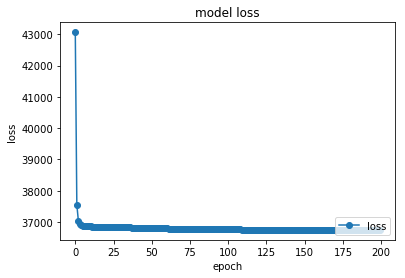

In [86]:
plot_history(history)

In [87]:
import json
with open('vae_256_mean_history.json', 'w') as fw:
    json.dump(history.history, fw, indent=4)

## Evaluate with test dataset

In [13]:
#score = model.evaluate(x_test, x_test, verbose=1)
#print(score)

3000/3000 [==============================] - 29s    
0.562157740275


## Visualize original image and reconstructed image

In [88]:
test = model.predict(x_train)

In [89]:
# definition to show original image and reconstructed image
def showOrigDec(orig, dec, num=10):
    n = num
    plt.figure(figsize=(20, 4))
    image_shape = (256, 256, 3)

    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i+1)
        plt.imshow(orig[i].reshape(image_shape))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i +1 + n)
        plt.imshow(dec[i].reshape(image_shape))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

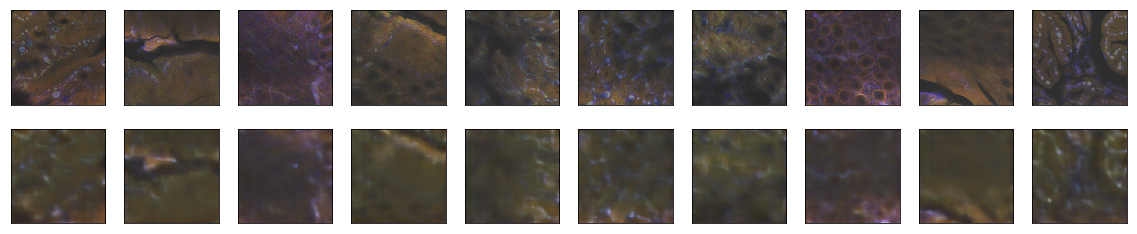

In [90]:
showOrigDec(x_train, test)

## PCA hidden output

In [44]:
model, input_img, encoded = set_ae(summary=False, channel=3)
model.load_weights("weights/ae_256_model.h5")

In [45]:
# Load Encoder model
encoder = Model(input_img, encoded)

# Extract hidden vector
hidden = encoder.predict(x_train)
hidden_vector  = [vector.flatten() for vector in hidden]

In [46]:
# PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(hidden_vector)
transformed = pca.fit_transform(hidden_vector)

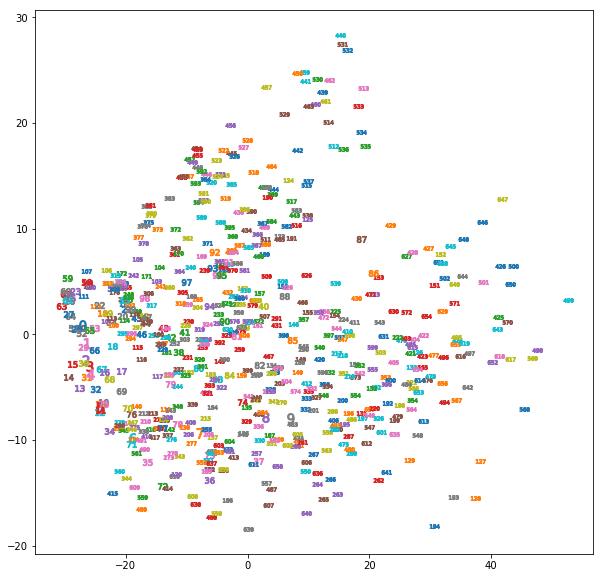

In [47]:
# Visualize PCA result. Each number means file index.
plt.figure(figsize=(10,10),dpi=200)
for i in range(len(transformed)):
    plt.plot(transformed[i, 0], transformed[i, 1], marker='$'+img_files[i].split('/')[-1].split('-')[0]+'$', markersize=10)

## VAE generate Consecutive cancer Transformation

In [91]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_hid_decoded = decoder_hid(decoder_input)
_up_decoded = decoder_upsample(_hid_decoded)
_reshape_decoded = decoder_reshape(_up_decoded)
_deconv_1_decoded = decoder_deconv_1_upsamp(_reshape_decoded)
_deconv_2_decoded = decoder_deconv_2_upsamp(_deconv_1_decoded)
_deconv_3_decoded = decoder_deconv_3_upsamp(_deconv_2_decoded)
_x_decoded_relu = decoder_deconv_4_upsamp(_deconv_3_decoded)
_x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
generator = Model(decoder_input, _x_decoded_mean_squash)

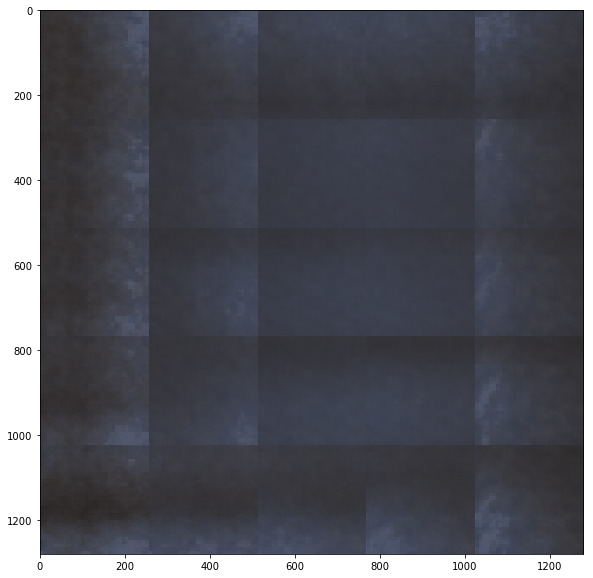

In [92]:
from scipy.stats import norm
# display a 2D manifold of the digits
n = 5  # figure with 15x15 digits
digit_size = 256

figure = np.zeros((digit_size * n, digit_size * n,3))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))


for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)[0]
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size,:] = x_decoded

plt.figure(figsize=(10, 10))
plt.imshow(figure[:,:,::-1])
plt.show()

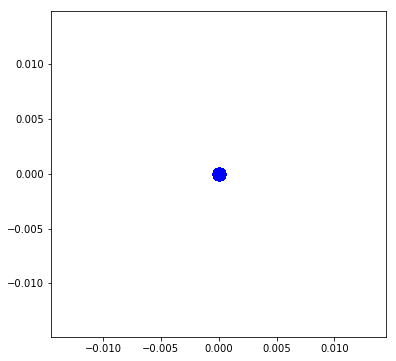

In [73]:
encoder = Model(x, hidden)

# display a 2D plot of the digit classes in the latent space
x_train_encoded = encoder.predict(x_train, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_train_encoded[:, 0], x_train_encoded[:, 1],s = 150,c='blue')
plt.show()

In [71]:
figure.shape

(1280, 1280, 3)

In [41]:
def set_ae(summary=True, model_to_png=False, channel=3):

    input_img = Input(shape=(256, 256, channel))
    x = Conv2D(16, (3, 3), padding='same')(input_img)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(64, (3, 3), padding='same')(encoded)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(channel, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    decoded = Activation('sigmoid')(x)

    model = Model(input_img, decoded)

    if model_to_png:
        plot_model(model, to_file='./vae_model.png', show_shapes=True)
    if summary:
        model.summary()

    return model, input_img, encoded